# JSON GoPro metadata processing

## Affichage des données

First let us import the data. Change the paths if needed.

In [134]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with open("../json/GH010025.MP4.json", "r") as f:
    video1_data1 = json.load(f)
with open("../json/GH020025.MP4.json", "r") as f:
    video1_data2 = json.load(f)

with open("../json/GH010024.MP4.json", "r") as f:
    video2_data1 = json.load(f)
with open("../json/GH020024.MP4.json", "r") as f:
    video2_data2 = json.load(f)
with open("../json/GH030024.MP4.json", "r") as f:
    video2_data3 = json.load(f)
list_data = [video1_data1, video1_data2, video2_data1, video2_data2, video2_data3]

The following 2 blocks of code allow to visualize the data to check if it is the correct data.

In [ ]:
# Voir les clés principales
for i, data in enumerate(list_data):
    print(f"Data {i+1} keys:")
    print(data.keys())
    print()

In [133]:
from pprint import pprint
with open("../json/GH010025.MP4.json", "r") as f:
    data = json.load(f)

# Affiche récursivement la structure jusqu’à une profondeur de 2 ou 3
for key in data:
    print(f"\n== Clé principale : {key} ==")
    if isinstance(data[key], dict):
        for subkey in data[key]:
            print(f"  - {subkey}: type={type(data[key][subkey])}")
            if isinstance(data[key][subkey], list) and len(data[key][subkey]) > 0:
                print(f"    Exemple d’entrée : {data[key][subkey][0]}")
    elif isinstance(data[key], list) and len(data[key]) > 0:
        print(f"  Liste de longueur {len(data[key])}")
        print(f"  Exemple d’entrée : {data[key][0]}")
    else:
        print(f"  Type: {type(data[key])}, Valeur: {data[key]}")


== Clé principale : img_timestamps_s ==
  Liste de longueur 42420
  Exemple d’entrée : 0.0

== Clé principale : ACCL ==
  - data: type=<class 'list'>
    Exemple d’entrée : [9.470023980815348, -1.223021582733813, 2.338129496402878]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.001331

== Clé principale : GYRO ==
  - data: type=<class 'list'>
    Exemple d’entrée : [0.003194888178913738, 0.0, -0.0010649627263045794]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.001331

== Clé principale : GPS5 ==
  - data: type=<class 'list'>
    Exemple d’entrée : [48.6139418, 2.4291544, 96.877, 0.0, 0.0]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.050368

== Clé principale : GRAV ==
  - data: type=<class 'list'>
    Exemple d’entrée : [-0.12784203619495224, 0.9633777886288034, 0.23560289315469832]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.0

== Clé principale : MAGN ==
  - data: type=<class 'list'>
    Exemple d’entrée : [36.0,

The following block of code concatenates a list of multiple .MP4 GoPro metadata json variables into one for easier manipulation and interpretation into one video.

In [130]:
# Créer les DataFrames pour toutes les clés de toutes les vidéos
list_data_video1 = [video1_data1, video1_data2]
list_data_video2 = [video2_data1, video2_data2, video2_data3]

dfs_video_1 = {}
dfs_video_2 = {}

def concatenate_dicts_by_key(dict_list):
    """
    Concatenates a list of dictionaries with potentially nested structures,
    ensuring that 'timestamps_s' values are stacked (i.e., made continuous).

    Parameters
    ----------
    dict_list : list of dict
        A list of dictionaries where each dictionary may contain nested structures

    Returns
    -------
    merged: dict.
        A single merged dictionary with combined and time-shifted values.
    """
    merged = {}
    time_offsets = {}  # Store per-key offset for nested timestamps

    for d in dict_list:
        for key, value in d.items():
            if isinstance(value, dict):
                # Nested dictionary (e.g., ACCL: {data: [...], timestamps_s: [...]})
                if key not in merged:
                    merged[key] = {}
                    time_offsets[key] = 0.0

                # Prepare nested structure if needed
                for sub_key, sub_val in value.items():
                    if sub_key not in merged[key]:
                        merged[key][sub_key] = []

                    if sub_key == "timestamps_s":
                        # Offset this timestamp list
                        offset = time_offsets[key]
                        shifted = [t + offset for t in sub_val]
                        merged[key][sub_key].extend(shifted)

                        # Update offset: assume timestamps_s is sorted
                        if sub_val:
                            time_offsets[key] += sub_val[-1] - sub_val[0]
                    else:
                        merged[key][sub_key].extend(sub_val)

            elif isinstance(value, list):
                # Flat key like img_timestamps_s (we treat it like timestamps)
                if key not in merged:
                    merged[key] = []
                    time_offsets[key] = 0.0

                if key.endswith("timestamps_s"):
                    offset = time_offsets[key]
                    shifted = [t + offset for t in value]
                    merged[key].extend(shifted)
                    if value:
                        time_offsets[key] += value[-1] - value[0]
                else:
                    merged[key].extend(value)

            else:
                print(f"Unexpected value type for key '{key}': {type(value)}")
                if key not in merged:
                    merged[key] = []
                merged[key].append(value)

    return merged


data_video1 = concatenate_dicts_by_key(list_data_video1)
data_video2 = concatenate_dicts_by_key(list_data_video2)

The following block checks if the concatenation worked by displaying the results.

In [131]:
print("Data Video 1:")
print(data_video1.keys())
key = "ACCL"
samples = data_video1[key]
print(f"Number of samples in {key}: {len(samples)}")

print("Data Video 2:")
print(data_video2.keys())

# Print the length of the ACCL samples before and after the concatenation
print(f"Number of samples in {key}: {len(data_video1[key]['data'])}")
print(f"Number of samples in {key}: {len(video1_data1[key]['data'])} +", f"{len(video1_data2[key]['data'])}", f"= {len(video1_data1[key]['data']) + len(video1_data2[key]['data'])}")

Data Video 1:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])
Number of samples in ACCL: 2
Data Video 2:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])
Number of samples in ACCL: 237913
Number of samples in ACCL: 141058 + 96855 = 237913


The following block plots all sensor data with one graph for each sensor and each video.

DataFrames for Video 1:
ACCL: 237913 rows, 5 columns
GYRO: 237913 rows, 5 columns
GPS5: 21569 rows, 7 columns
GRAV: 71552 rows, 5 columns
MAGN: 29739 rows, 5 columns
CORI: 71552 rows, 6 columns
IORI: 71552 rows, 6 columns
DataFrames for Video 2:
ACCL: 313522 rows, 5 columns
GYRO: 313522 rows, 5 columns
GPS5: 28557 rows, 7 columns
GRAV: 94300 rows, 5 columns
MAGN: 39190 rows, 5 columns
CORI: 94300 rows, 6 columns
IORI: 94300 rows, 6 columns


Video 1 DataFrames: ----------------------------------------------------------------------------------------------------


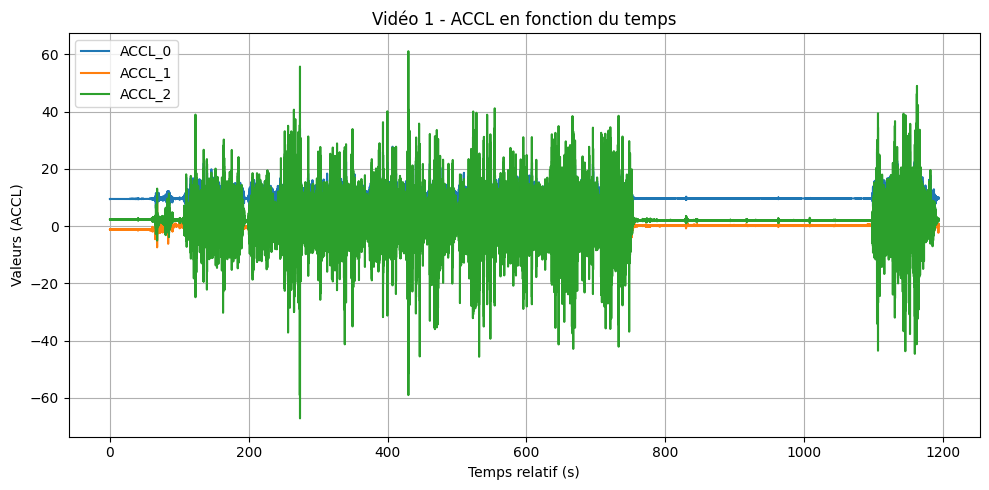

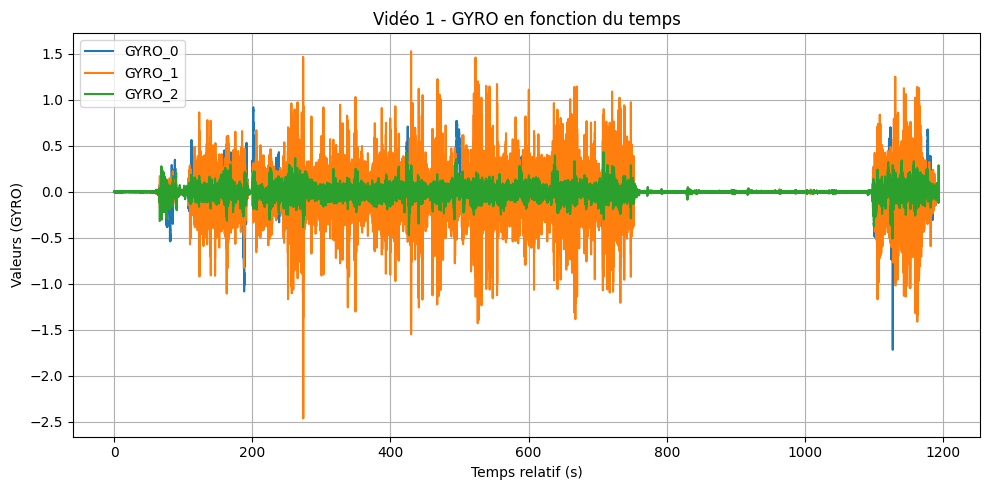

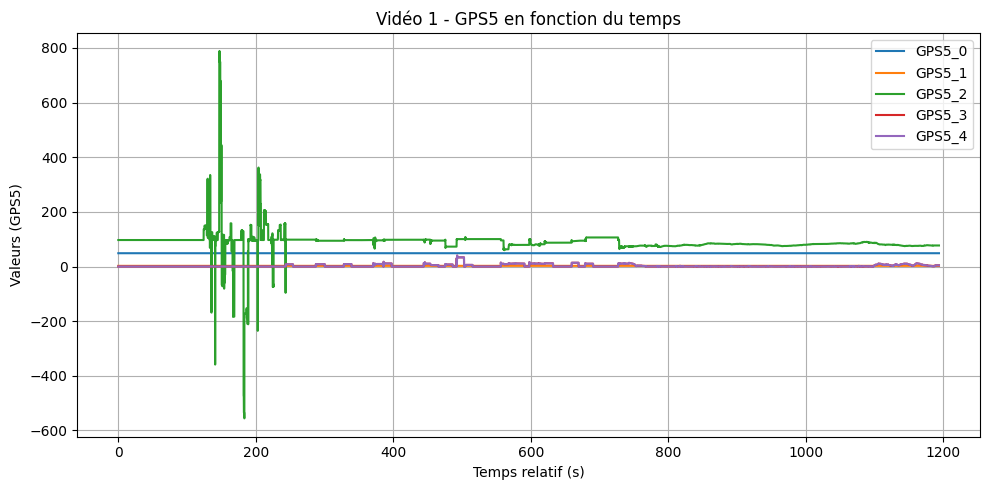

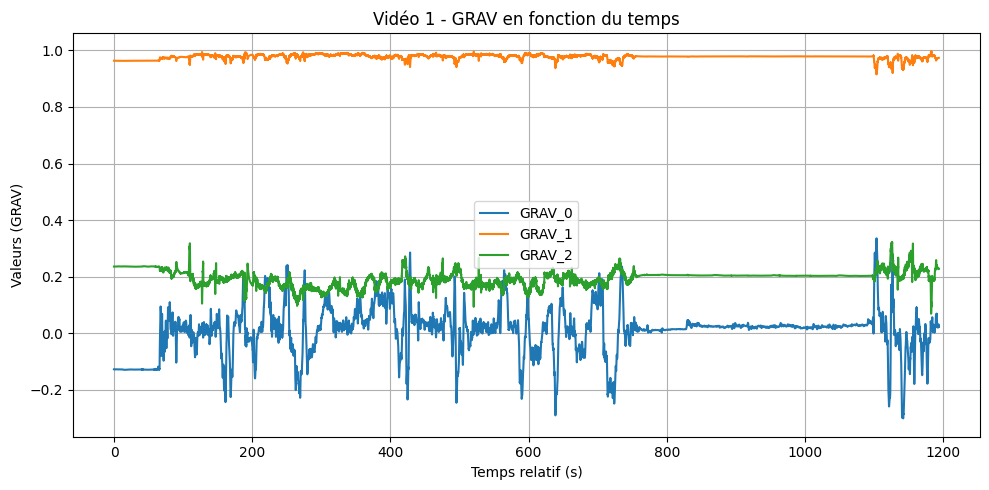

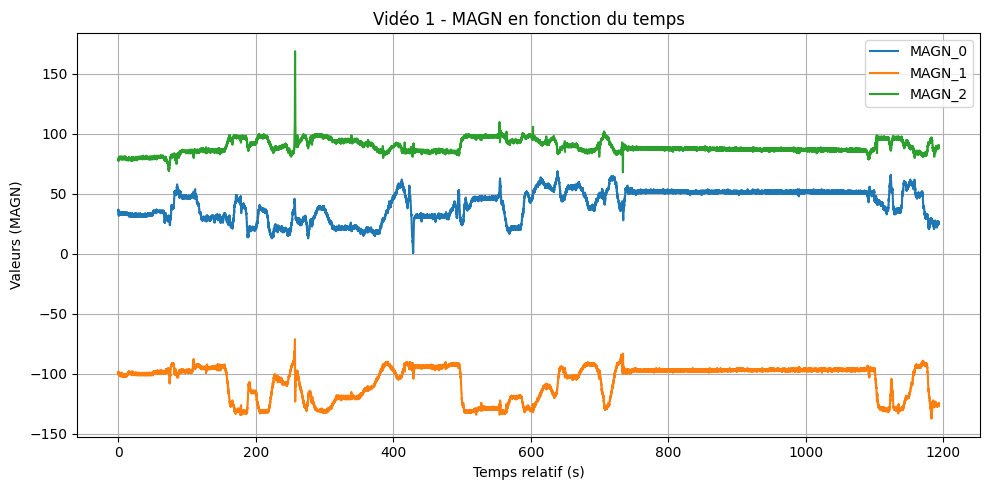

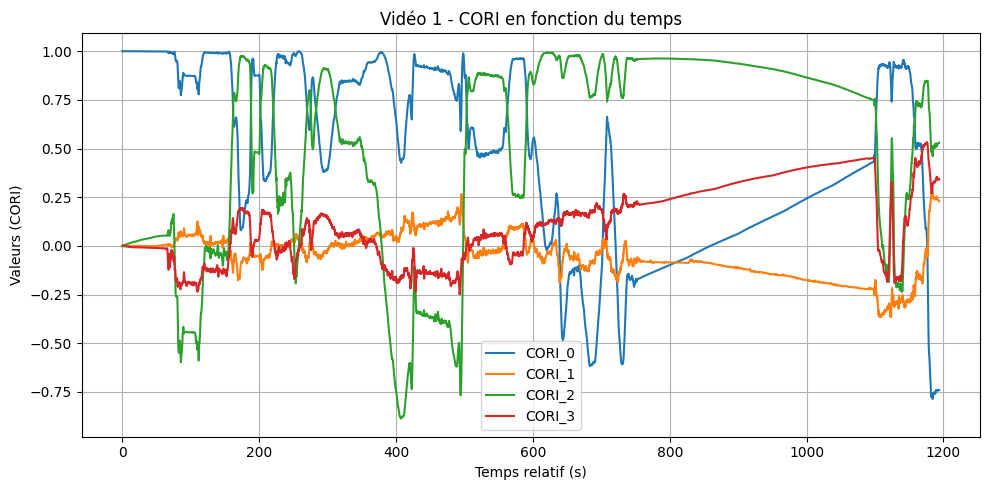

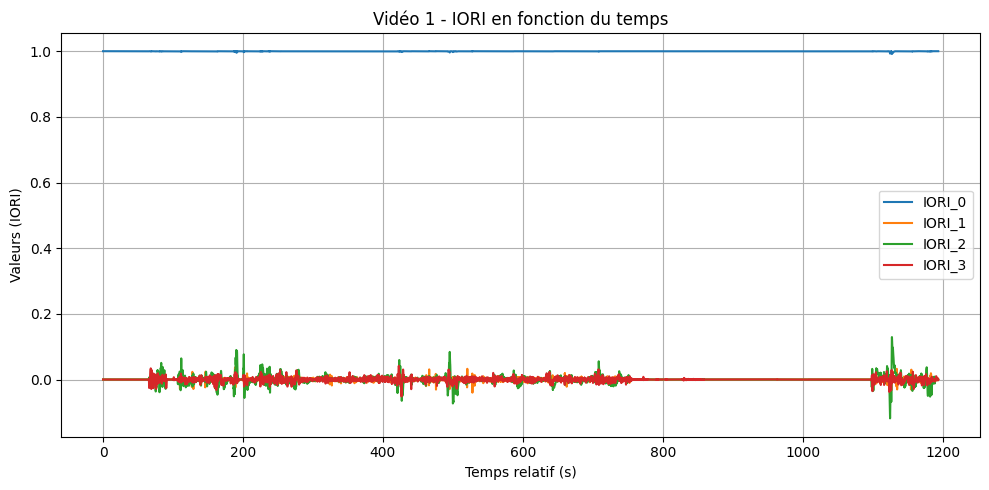

Video 2 DataFrames: ----------------------------------------------------------------------------------------------------


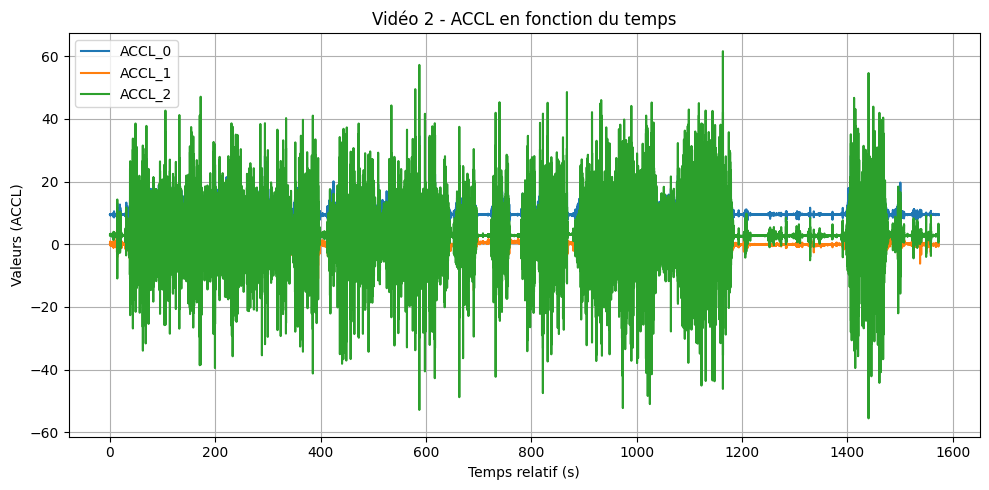

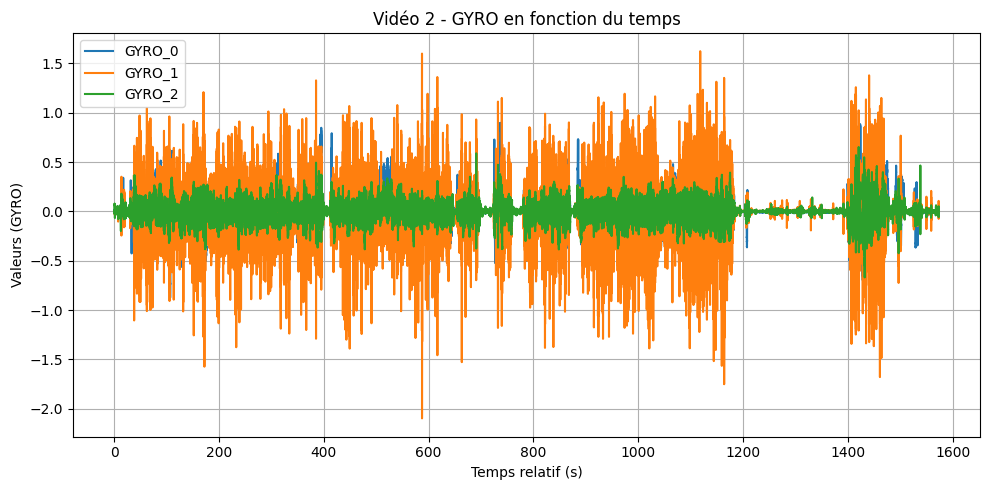

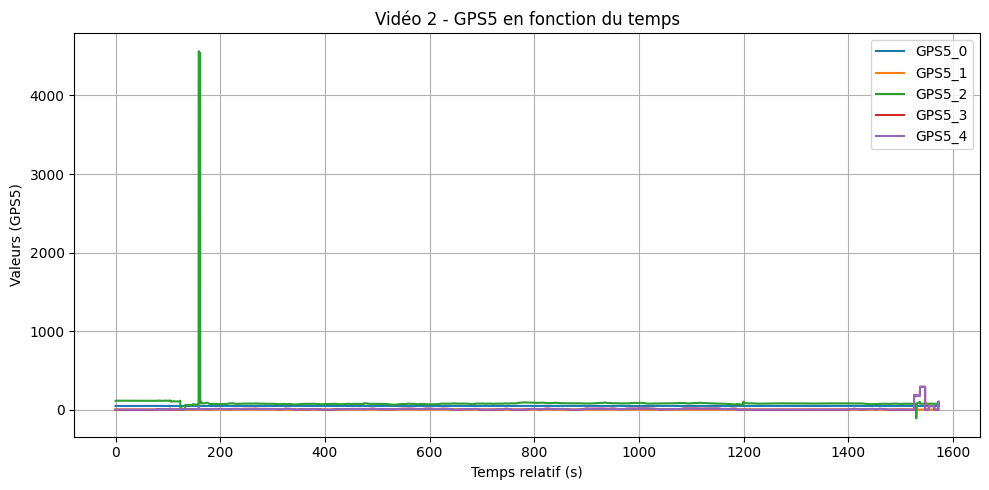

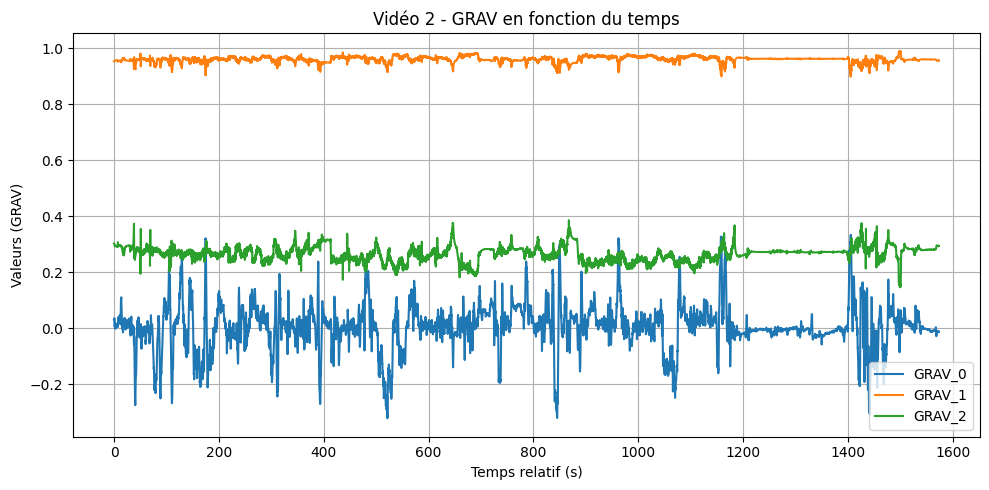

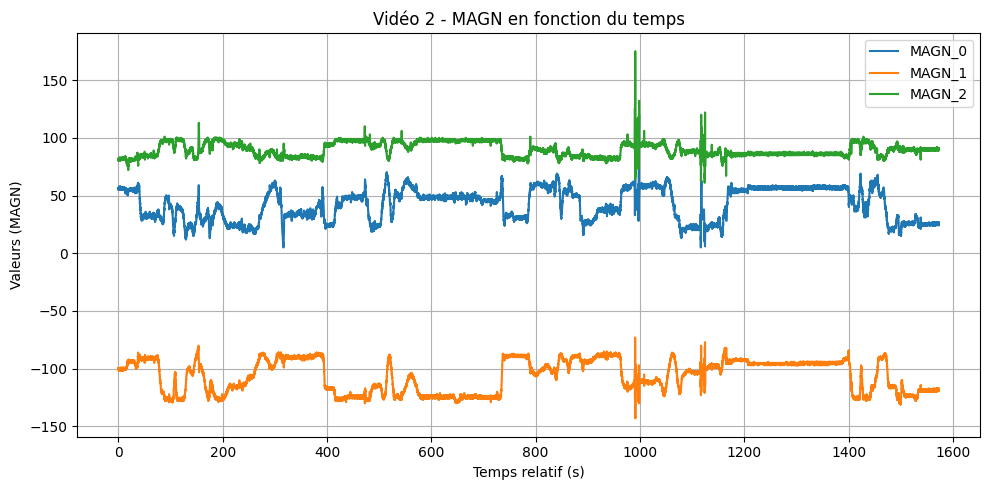

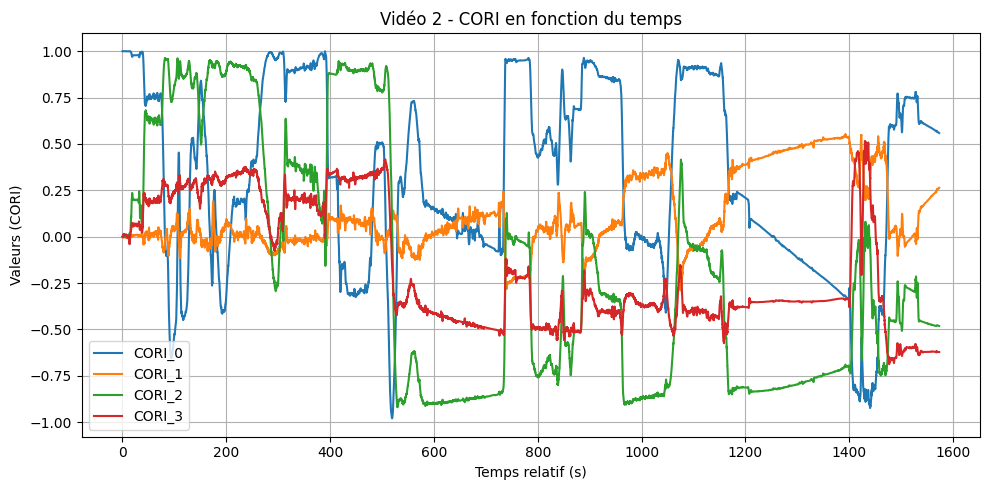

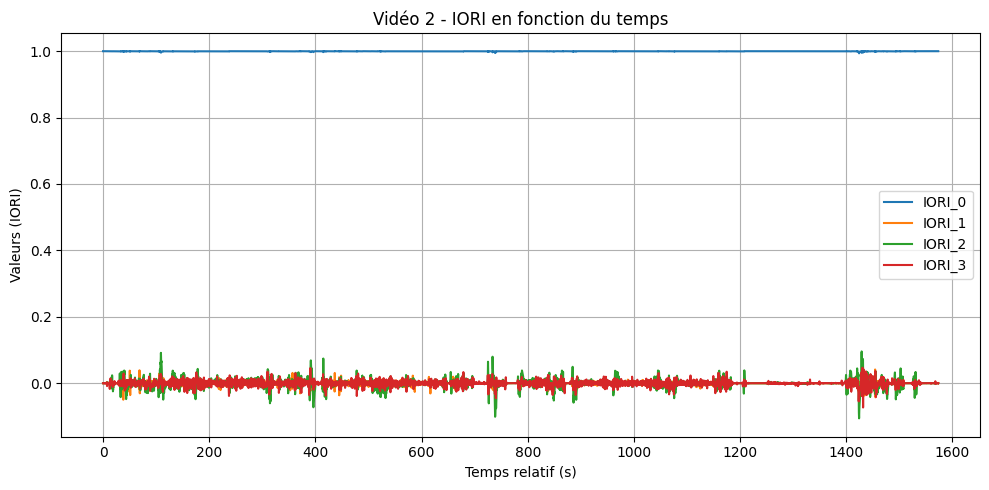

In [132]:
def parse_video_dict(video_dict):
    """
    Converts a sensor dictionary into a dict of DataFrames per sensor (one DataFrame for ACCL, one for GRAV and so on).
    """
    dict_of_dfs = {}
    for key, value in video_dict.items():
        # Skip if key is just the image timestamps
        if key == "img_timestamps_s":
            continue

        if isinstance(value, dict) and "data" in value and "timestamps_s" in value:
            samples = value["data"]
            timestamps = value["timestamps_s"]

            # Skip if no data or inconsistent
            if not samples or not timestamps or len(samples) != len(timestamps):
                print(f"Skipping {key}: no data or inconsistent lengths.")
                continue

            num_cols = len(samples[0]) if isinstance(samples[0], (list, tuple)) else 1# check if samples is a list of lists or a single list
            if num_cols == 1:
                df = pd.DataFrame({f"{key}_0": samples})
            else:
                col_names = [f"{key}_{i}" for i in range(num_cols)]
                df = pd.DataFrame(samples, columns=col_names)

            df["time"] = timestamps
            df["time_rel"] = df["time"] - df["time"][0] # starting from 0 for plotting
            dict_of_dfs[key] = df

    return dict_of_dfs

def plot_sensor_data(dict_of_dfs, label_prefix=""):
    """
    Plots all sensor data from a dict of DataFrames.
    """
    for key, df in dict_of_dfs.items():
        if df.empty or "time_rel" not in df:
            print(f"Skipping {key}: DataFrame is empty or missing 'time_rel' column.")
            continue

        value_cols = [col for col in df.columns if col not in ["time", "time_rel"]]
        plt.figure(figsize=(10, 5))
        for col in value_cols:
            plt.plot(df["time_rel"], df[col], label=col)

        plt.xlabel("Temps relatif (s)")
        plt.ylabel(f"Valeurs ({key})")
        plt.title(f"{label_prefix}{key} en fonction du temps")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Create DataFrames for each video
dfs_video_1 = parse_video_dict(data_video1)
dfs_video_2 = parse_video_dict(data_video2)

# Verifies that the DataFrames were created correctly
print("DataFrames for Video 1:")
for key, df in dfs_video_1.items():
    print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")
print("DataFrames for Video 2:")
for key, df in dfs_video_2.items():
    print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")

print("\n")

# Plot sensor data for each video
print("Video 1 DataFrames:", "-" * 100)
plot_sensor_data(dfs_video_1, label_prefix="Vidéo 1 - ")
print("Video 2 DataFrames:", "-" * 100)
plot_sensor_data(dfs_video_2, label_prefix="Vidéo 2 - ")

The acceleration data is consistent with the observation of the video, which indicates that the data processing was successful. The moments when the camera is stationary, as the `ACCL` acceleration is zero, correspond to the moments when the stabilized orientation `IORO` is at its lowest, indicating that the graphs are consistent with each other.

**Graph analysis**:
* **Acceleration**: `ACCL_2` corresponds to the forward/backward acceleration of the motorcycle because it is positively non-zero on average, `ACCL_0` to vertical acceleration since its average is close to 10, which matches Earth's acceleration, and `ACCL_1` corresponds to lateral acceleration since it is zero on average, indicating that the road is mostly straight.
* **Gyroscope**:
* **GPS**: there are sometimes outlier data points (spikes) that should be removed.
* **Gravity**: `GRAV_1` corresponds to vertical acceleration as it is close to $1\ g$, `GRAV_2` to forward/backward acceleration because it is non-zero and positive, and therefore `GRAV_0` corresponds to lateral acceleration.
* **Magnetic field**:
* **Camera orientation**:
* **GoPro stabilized orientation**:




## Calcul du roulis, lacet, et tangage de la moto

### Roll, pitch and yaw
We use various GoPro metadata to compute roll, pitch and yaw using multiple methods to ensure the most precise values.

#### Roll, pitch and yaw from gyroscope
Integration of angular velocity:
```python
roll[i+1]  = roll[i] + gyro_x[i] * Δt
pitch[i+1] = pitch[i] + gyro_y[i] * Δt
yaw[i+1]   = yaw[i] + gyro_z[i] * Δt
```
But these values drifts over time (gyroscope bias) from reality because of the small approximation mistakes each time.

#### Roll and pitch from accelerometer
Static estimation: because gravity is always down, you can project it on the sensor frame.
```python
roll  = atan2(acc_y, acc_z)
pitch = atan2(-acc_x, sqrt(acc_y**2 + acc_z**2))
```
This gives good long-term orientation to correct for the first indicator, but poor during acceleration or vibration. Indeed, if the device is moving, accelerating, or vibrating, the acceleration includes not only motion, shocks, engine vibration, bumps from the vehicle. But in this case the acceleration is at most a few $g$.

#### Yaw from compass

### Filters

#### Complentary filter: blend both previous estimates
This method combines the first and second steps.
With `alpha` being a tuning parameter:
```python
roll  = alpha * (roll + gyro_x * Δt) + (1 - alpha) * roll_acc
pitch = alpha * (pitch + gyro_y * Δt) + (1 - alpha) * pitch_acc
```
You get short-term reactivity from the gyroscope, and long-term stability from the accelerometer.

#### Kalman Filter: sensor fusion
This provides the best results:
- Model sensor noise and bias
- Fuse ACCL (first step) + GYRO (second step) + MAGN (third step)
- Estimate full state with uncertainty

In [ ]:
def kalman_filter_orientation(acc, gyro, dt, Q_angle=0.001, Q_bias=0.003, R_measure=0.03):
    """
    Kalman filter for estimating roll and pitch angles from accelerometer and gyroscope.
    Only roll and pitch are handled here.
    """
    num_samples = len(dt)
    kalman_roll = np.zeros(num_samples)
    kalman_pitch = np.zeros(num_samples)

    # Initial state
    angle = np.zeros(2)
    bias = np.zeros(2)
    P = np.zeros((2, 2, 2))  # P matrix for roll and pitch

    for i in range(1, num_samples):
        for j in range(2):  # 0 for roll, 1 for pitch
            # Predict
            rate = gyro[i, j] - bias[j]
            angle[j] += dt[i] * rate
            P[j] += dt[i] * (np.array([[Q_angle, 0], [0, Q_bias]]) +
                             np.dot(P[j], [[1, -dt[i]], [0, 1]]) +
                             np.dot([[1, -dt[i]], [0, 1]], P[j].T))

            # Measurement update
            if j == 0:  # roll
                acc_angle = np.arctan2(acc[i, 1], acc[i, 2])
            else:       # pitch
                acc_angle = np.arctan2(-acc[i, 0], np.sqrt(acc[i, 1]**2 + acc[i, 2]**2))

            y = acc_angle - angle[j]
            S = P[j][0, 0] + R_measure
            K = [P[j][0, 0] / S, P[j][1, 0] / S]

            angle[j] += K[0] * y
            bias[j] += K[1] * y

            P[j] = np.dot([[1 - K[0], 0], [-K[1], 1]], P[j])

        kalman_roll[i] = np.degrees(angle[0])
        kalman_pitch[i] = np.degrees(angle[1])

    return kalman_roll, kalman_pitch

kalman_roll, kalman_pitch = kalman_filter_orientation(acc_interp, gyro_interp, dt)

CORRECT THE X, Y AND Z !!!

Orientation Data Video 1: ----------------------------------------------------------------------------------------------------


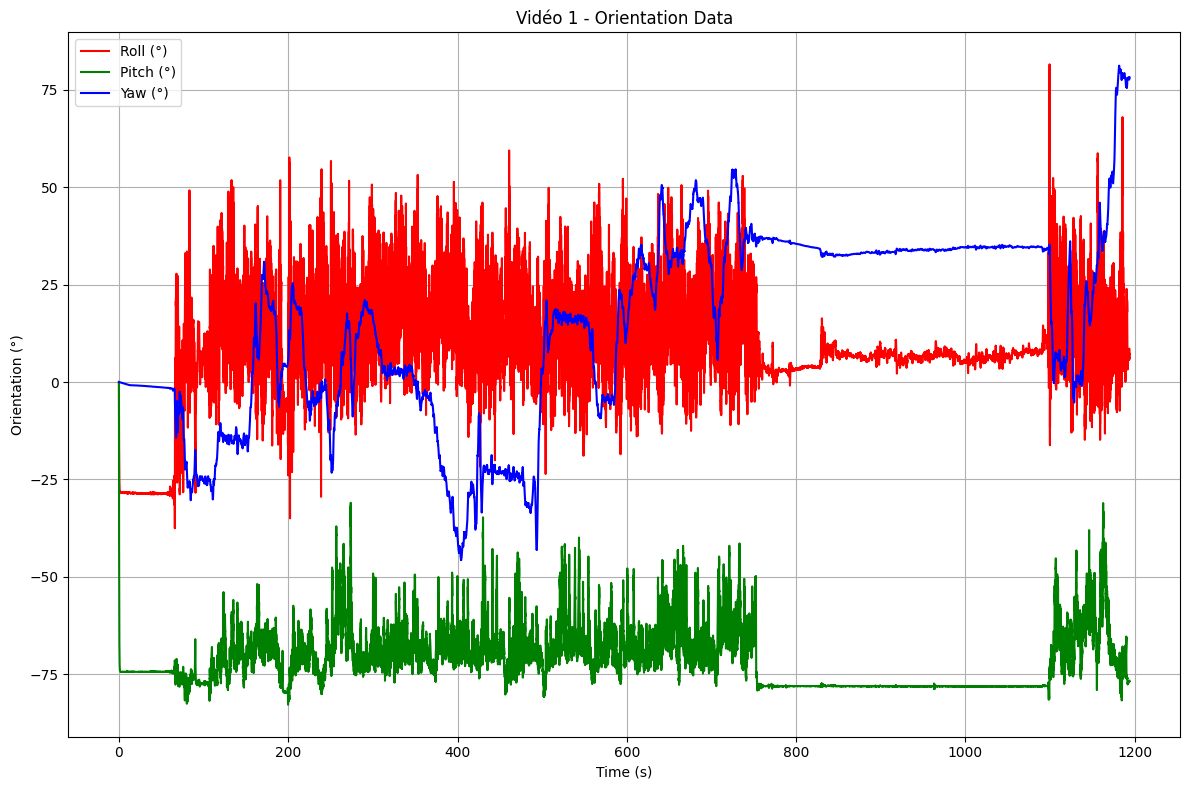

Orientation Data Video 2: ----------------------------------------------------------------------------------------------------


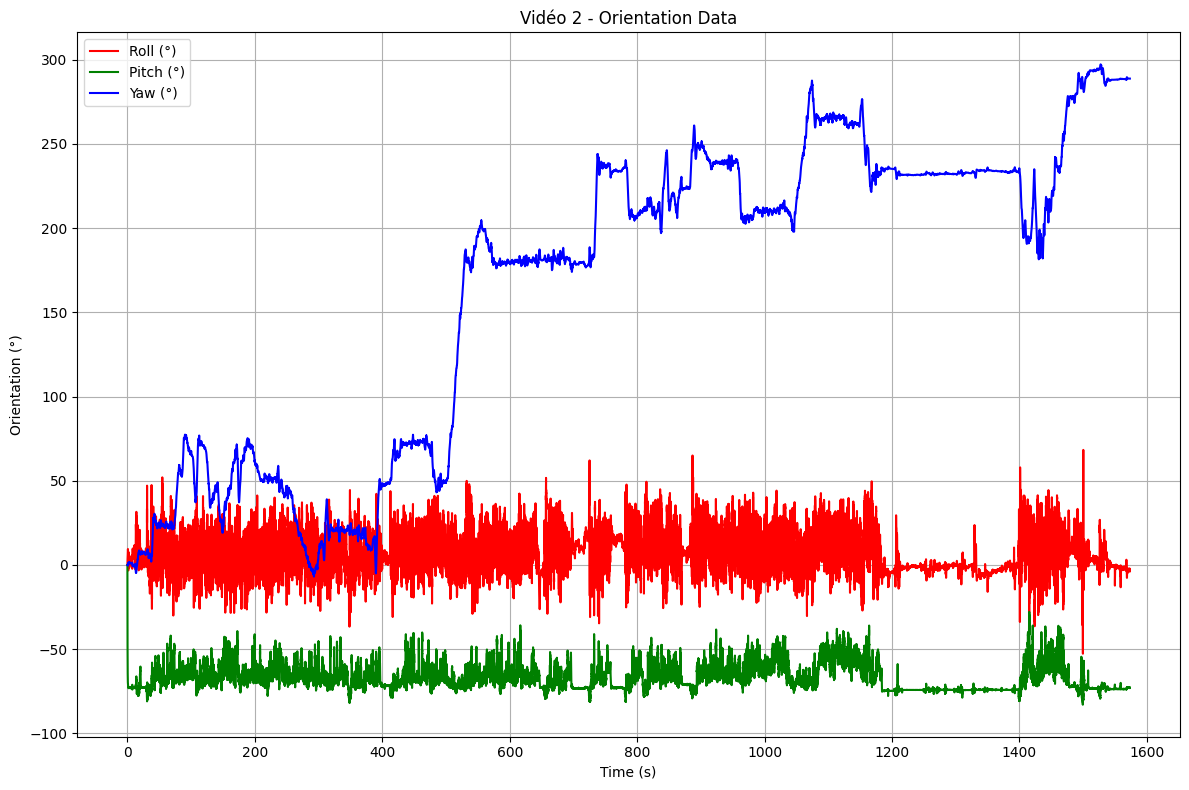

In [ ]:
def compute_orientation_from_data(data):
    """
    Compute roll, pitch, yaw from raw GoPro sensor data using:
    1. Gyroscope integration
    2. Accelerometer estimation
    3. Complementary filter
    4. Kalman filter placeholder
    """
    # Extract sensor values and timestamps
    gyro_data = np.array(data["GYRO"]["data"])       # Angular velocity in rad/s
    gyro_t = np.array(data["GYRO"]["timestamps_s"])

    acc_data = np.array(data["ACCL"]["data"])        # Linear acceleration in m/s^2
    acc_t = np.array(data["ACCL"]["timestamps_s"])

    magn_data = np.array(data["MAGN"]["data"])       # Magnetometer data (µT)
    magn_t = np.array(data["MAGN"]["timestamps_s"])

    # Interpolate all data on a common time vector
    common_time = np.union1d(gyro_t, acc_t)
    common_time = np.union1d(common_time, magn_t)

    # Computes the differences in time between each pair consecutive timestamps
    dt = np.diff(common_time, prepend=common_time[0])

    gyro_interp = np.array([np.interp(common_time, gyro_t, gyro_data[:, i]) for i in range(3)]).T
    acc_interp = np.array([np.interp(common_time, acc_t, acc_data[:, i]) for i in range(3)]).T
    magn_interp = np.array([np.interp(common_time, magn_t, magn_data[:, i]) for i in range(3)]).T

    # Step 1: Orientation from gyroscope (integration)
    angles_gyro = np.zeros((len(common_time), 3))  # roll, pitch, yaw
    for i in range(1, len(common_time)):
        angles_gyro[i] = angles_gyro[i - 1] + gyro_interp[i] * dt[i]

    # Step 2: Orientation from accelerometer (gravity-based estimation)
    angles_acc = np.zeros((len(common_time), 2))  # roll, pitch only
    for i in range(len(common_time)):
        ax, ay, az = acc_interp[i]
        roll_acc = np.arctan2(ay, az)
        pitch_acc = np.arctan2(-ax, np.sqrt(ay**2 + az**2))
        angles_acc[i] = [roll_acc, pitch_acc]

    # Step 3: Complementary filter
    alpha = 0.98 # complementary filter coefficient
    angles_comp = np.zeros((len(common_time), 3))  # roll, pitch, yaw
    for i in range(1, len(common_time)):
        # Gyro integration
        roll = angles_comp[i - 1, 0] + gyro_interp[i, 0] * dt[i]
        pitch = angles_comp[i - 1, 1] + gyro_interp[i, 1] * dt[i]
        yaw = angles_comp[i - 1, 2] + gyro_interp[i, 2] * dt[i]

        # Acc-based correction
        roll_acc, pitch_acc = angles_acc[i]
        roll = alpha * roll + (1 - alpha) * roll_acc
        pitch = alpha * pitch + (1 - alpha) * pitch_acc

        angles_comp[i] = [roll, pitch, yaw]

    # Convert to degrees
    angles_gyro_deg = np.degrees(angles_gyro)
    angles_acc_deg = np.degrees(angles_acc)
    angles_comp_deg = np.degrees(angles_comp)

    # Package as DataFrame
    df = pd.DataFrame({
        "time": common_time,
        "gyro_roll": angles_gyro_deg[:, 0],
        "gyro_pitch": angles_gyro_deg[:, 1],
        "gyro_yaw": angles_gyro_deg[:, 2],
        "acc_roll": np.pad(angles_acc_deg[:, 0], (0, len(common_time) - len(angles_acc_deg[:, 0]))),
        "acc_pitch": np.pad(angles_acc_deg[:, 1], (0, len(common_time) - len(angles_acc_deg[:, 1]))),
        "comp_roll": angles_comp_deg[:, 0],
        "comp_pitch": angles_comp_deg[:, 1],
        "comp_yaw": angles_comp_deg[:, 2],
    })

    return df

# Compute orientation for each video
orientation_video_1 = compute_orientation_from_data(data_video1)
orientation_video_2 = compute_orientation_from_data(data_video2)

# Affichage des données
def plot_orientation_data(df, label_prefix=""):
    """
    Plots the orientation data (roll, pitch, yaw) from a DataFrame.
    """
    plt.figure(figsize=(12, 8))
    plt.plot(df["time"], df["comp_roll"], label="Roll (°)", color='r')
    plt.plot(df["time"], df["comp_pitch"], label="Pitch (°)", color='g')
    plt.plot(df["time"], df["comp_yaw"], label="Yaw (°)", color='b')

    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (°)")
    plt.title(f"{label_prefix}Orientation Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot orientation data for each video
print("Orientation Data Video 1:", "-" * 100)
plot_orientation_data(orientation_video_1, label_prefix="Vidéo 1 - ")
print("Orientation Data Video 2:", "-" * 100)
plot_orientation_data(orientation_video_2, label_prefix="Vidéo 2 - ")

## Synchronisation des données et superposition sur vidéo